In [1]:
import os
import sys
import typing as t
from PIL import Image

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import skimage.color

# add src to path
sys.path.append('../..')
from utils.db_helper import get_image_data
# from utils.color_space_operations import calculate_difference_image

In [9]:
SOURCE_DIR_STYLE = R"F:\master-thesis-databases\classification_db\fake"
SOURCE_DIR_FFHQ = R"F:\master-thesis-databases\classification_db\real"
base_save_path = os.path.join("..", "..", "..", "exp", "Histograms")


In [ ]:
def all_colorspaces_from_rgb(np_rgb_img: np.ndarray)-> np.ndarray:
    """R,G,B,H,S,V,Y,Cb,Cr"""
    if np_rgb_img.shape[2] < 3 or len(np_rgb_img.shape) != 3:
        raise ValueError("Bad shape of input image")
    np_img_hsv = skimage.color.rgb2hsv(np_rgb_img)
    np_img_ycbcr = skimage.color.rgb2ycbcr(np_rgb_img) / 255
    # (x,y,9) shape insted of (x,y,3)
    new_shape = list(np_rgb_img.shape[:2])+[9]
    np_img_all_colors = np.empty(new_shape)
    np_img_all_colors[:,:,:3] = np_rgb_img
    np_img_all_colors[:,:,3:6] = np_img_hsv
    np_img_all_colors[:,:,6:] = np_img_ycbcr
    return np_img_all_colors

In [8]:
def calculate_avg_histogram(dataset_gen: t.Generator[np.ndarray, None, None], bins=256, hist_range=(0,1), channels=3):
    number_of_images = 0
    np_avg_hist = np.zeros((bins,channels), dtype=np.float64)
    for np_img in dataset_gen:
        for colorspace in range(channels):
            hist, _ = np.histogram(np_img[:,:,colorspace],                                               density=True, bins=bins, range=hist_range)
            np_avg_hist[:,colorspace] += hist
        number_of_images += 1
        if np_avg_hist.max() > 0.95*np.finfo(np_avg_hist.dtype).max:
            raise ValueError("Dataset to large")
            break

    return np_avg_hist / number_of_images 

## Color componenets histograms

In [ ]:
def get_all_colorspaces_gen(dataset_gen):
    return (all_colorspaces_from_rgb(np_img) for np_img in dataset_gen)

In [ ]:
color_componenets = ("R", "G", "B", "H", "S", "V", "Y", "Cb", "Cr")
save_path = os.path.join(base_save_path, "Color_components_avg_histograms_sharey.png")
categories = ['real', 'fake']


In [ ]:
ffhq_gen = get_image_data(SOURCE_DIR_FFHQ, type='float', grayscale=False, max_number_of_images=100)
style_gen = get_image_data(SOURCE_DIR_STYLE, type='float', grayscale=False, max_number_of_images=100)
real_hist = calculate_avg_histogram(get_all_colorspaces_gen(ffhq_gen), channels=9)
fake_hist = calculate_avg_histogram(get_all_colorspaces_gen(style_gen), channels=9)

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(15,7))
fig.suptitle("Average histograms of each color component")
plt.subplots_adjust(hspace=0.5)
for i in range(9):
    axs[int(i/3),i%3].plot(np.linspace(0,1,num=256), real_hist[:,i])
    axs[int(i/3),i%3].plot(np.linspace(0,1,num=256), fake_hist[:,i])
    axs[int(i/3),i%3].legend(['real', 'fake'])
    axs[int(i/3),i%3].set_title(color_componenets[i])
#plt.savefig(save_path)
plt.show()   



## Color Componenets for difference images

In [15]:
def get_difference_img_gen(dataset_gen):
    for np_img in dataset_gen:
        np_all_colorspaces = all_colorspaces_from_rgb(np_img)
        np_int_img = float_to_int_img_conversion(np_all_colorspaces)
        np_result_img = calculate_difference_image(np_int_img)
        yield np_result_img

In [16]:
def float_to_int_img_conversion(np_img):
    if np_img.max() > 1 or np_img.min() < 0:
        raise ValueError('Image pixels not in (0,1) range')
    if not np.issubdtype(np_img.dtype, np.floating):
        raise ValueError("Image is not float")
    return (np_img*255).astype(np.uint8)


In [51]:
color_componenets = ("R", "G", "B", "H", "S", "V", "Y", "Cb", "Cr")
save_path = os.path.join(base_save_path, "Color_components_diff_avg_histograms_sharey.png")
categories = ['real', 'fake']

In [53]:
ffhq_gen = get_image_data(SOURCE_DIR_FFHQ, type='float', grayscale=False, max_number_of_images=100)
style_gen = get_image_data(SOURCE_DIR_STYLE, type='float', grayscale=False, max_number_of_images=100)
real_hist = calculate_avg_histogram(get_difference_img_gen(ffhq_gen), channels=9, hist_range=(0,255))
fake_hist = calculate_avg_histogram(get_difference_img_gen(style_gen), channels=9, hist_range=(0,255))

len: 100
len: 100


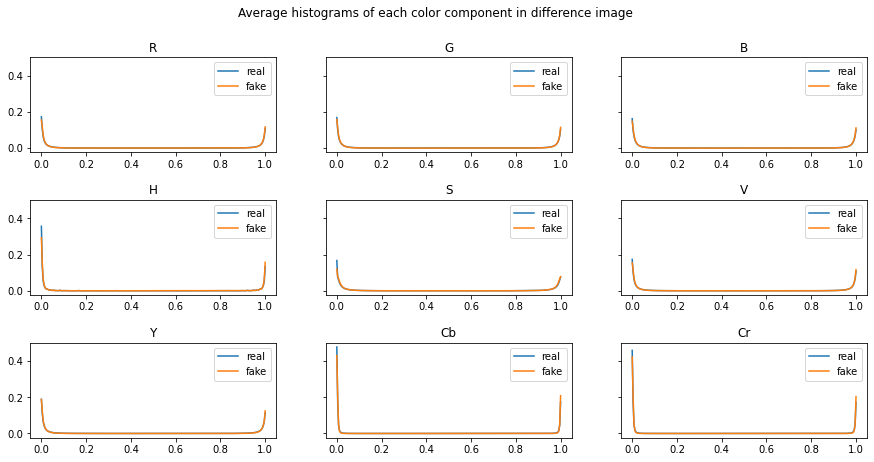

In [54]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(15,7))
fig.suptitle("Average histograms of each color component in difference image")
plt.subplots_adjust(hspace=0.5)
for i in range(9):
    axs[int(i/3),i%3].plot(np.linspace(0,1,num=256), real_hist[:,i])
    axs[int(i/3),i%3].plot(np.linspace(0,1,num=256), fake_hist[:,i])
    axs[int(i/3),i%3].legend(['real', 'fake'])
    axs[int(i/3),i%3].set_title(color_componenets[i])
plt.savefig(save_path)
#plt.show()  

In [47]:
def calculate_difference_image(np_img: np.ndarray) -> np.ndarray:
    """Calculate difference image that is convolution with (1,-1) filter

    Args:
        np_img (np.ndarray): input image, should be image with integer pixels in range 0-255

    Raises:
        ValueError: len(np_img.shape) other than 2 or 3

    Returns:
        np.ndarray: calculated diffference image
    """
    #TODO compatibility with floats and ints
    from scipy.ndimage.filters import convolve
    #mask = [[-1,1,1], [-1,-2,1], [1,1,1]]
    mask = [[0,0,0], [-1,1,0], [0,0,0]]
    np_filter = np.array(mask)
    np_diff_img = np.empty(np_img.shape)
    if len(np_img.shape) == 3:
        for i in range(np_img.shape[-1]):
            np_diff_img[:, :, i] = np.abs(convolve(np_img[:, :, i], np_filter))
    elif len(np_img.shape) == 2:
        np_diff_img = np.abs(convolve(np_img, np_filter))
    else:
        raise ValueError('Bad shape of the image')
    # only positive values
    #np_diff_img[np_diff_img<0] = 0
    return np_diff_img